# ps

> persistent scatterers identification

In [ ]:
#| default_exp cli/ps

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import zarr
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
import moraine as mr
from moraine.cli.logging import mc_logger

In [ ]:
#| export
@mc_logger
def amp_disp(rslc:str, # rslc stack
             adi:str, #output, amplitude dispersion index
             chunks:tuple[int,int]=None, # output data chunk size, same as rslc by default
            ):
    '''calculation the amplitude dispersion index from SLC stack.'''
    rslc_path = rslc
    adi_path = adi
    logger = logging.getLogger(__name__)
    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path,rslc_zarr)
    if chunks is None: chunks = rslc_zarr.chunks[:2]

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster() as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        cpu_rslc = da.from_array(rslc_zarr, chunks=(*chunks,*rslc_zarr.shape[2:]))
        logger.darr_info('rslc', cpu_rslc)
    
        logger.info(f'calculate amplitude dispersion index.')
        rslc = cpu_rslc.map_blocks(cp.asarray)
        rslc_delayed = rslc.to_delayed()
        adi_delayed = np.empty_like(rslc_delayed,dtype=object)
        with np.nditer(rslc_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                adi_delayed[idx] = delayed(mr.amp_disp,pure=True,nout=1)(rslc_delayed[idx])
                adi_delayed[idx] =da.from_delayed(adi_delayed[idx],shape=rslc.blocks[idx].shape[0:2],meta=cp.array((),dtype=cp.float32))
        adi = da.block(adi_delayed[...,0].tolist())
        
        # cpu_adi = adi.map_blocks(cp.asnumpy)
        logger.info(f'got amplitude dispersion index.')
        logger.darr_info('adi', adi)

        logger.info('saving adi.')
        cpu_adi = adi.map_blocks(cp.asnumpy)
        _adi = da.to_zarr(cpu_adi,adi_path,compute=False,overwrite=True)
        # adi_zarr = kvikio.zarr.open_cupy_array(adi_path,'w',shape=adi.shape, chunks=adi.chunksize, dtype=adi.dtype,compressor=kvikio.zarr.CompatCompressor.lz4())
        # _adi = da.store(adi,adi_zarr,compute=False,lock=False)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_adi)
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Using amplitude dispersion index (ADI) to identify persistent scatterers is first used in [@ferrettiPermanentScatterersSAR2001].

Usage:

In [ ]:
rslc = '../../data/rslc.zarr'
adi = './ps/adi.zarr'

In [ ]:
logger = mc.get_logger()

In [ ]:
if is_cuda_available():
    amp_disp(rslc,adi)

2024-04-30 22:37:30 - log_args - INFO - running function: amp_disp
2024-04-30 22:37:30 - log_args - INFO - fetching args:
2024-04-30 22:37:30 - log_args - INFO - rslc = '../../data/rslc.zarr'
2024-04-30 22:37:30 - log_args - INFO - adi = './ps/adi.zarr'
2024-04-30 22:37:30 - log_args - INFO - chunks = None
2024-04-30 22:37:30 - log_args - INFO - fetching args done.
2024-04-30 22:37:30 - zarr_info - INFO - ../../data/rslc.zarr zarray shape: (2500, 1834, 17)
2024-04-30 22:37:30 - zarr_info - INFO - ../../data/rslc.zarr zarray chunks: (1000, 1000, 17)
2024-04-30 22:37:30 - zarr_info - INFO - ../../data/rslc.zarr zarray dtype: complex64
2024-04-30 22:37:30 - amp_disp - INFO - starting dask CUDA local cluster.
2024-04-30 22:37:32 - amp_disp - INFO - dask local CUDA cluster started.
2024-04-30 22:37:32 - darr_info - INFO - rslc dask array shape: (2500, 1834, 17)
2024-04-30 22:37:32 - darr_info - INFO - rslc dask array chunksize: (1000, 1000, 17)
2024-04-30 22:37:32 - darr_info - INFO - rslc 

In [ ]:
adi = zarr.open('./ps/adi.zarr/','r')[:]

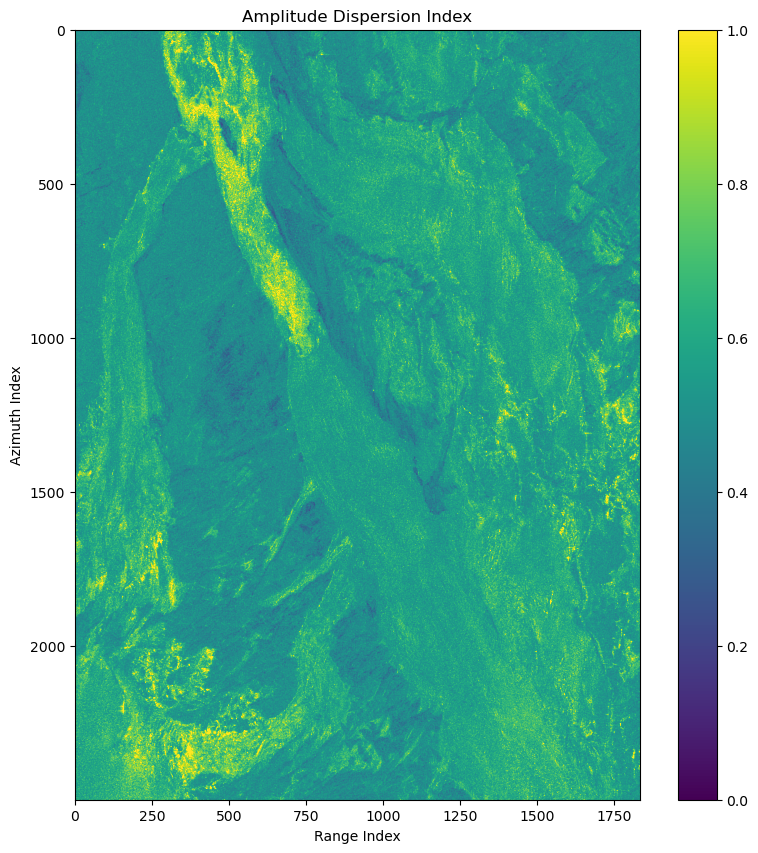

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(adi,vmin=0,vmax=1)
ax.set(title='Amplitude Dispersion Index',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

We can then select PS candidate according to adi:

In [ ]:
ps_can_gix = './ps/ps_can_gix.zarr'
mc.pc_logic_ras('./ps/adi.zarr/',ps_can_gix,'(ras>=0)&(ras<=0.3)')

2024-04-30 22:37:36 - log_args - INFO - running function: pc_logic_ras
2024-04-30 22:37:36 - log_args - INFO - fetching args:
2024-04-30 22:37:36 - log_args - INFO - ras = './ps/adi.zarr/'
2024-04-30 22:37:36 - log_args - INFO - gix = './ps/ps_can_gix.zarr'
2024-04-30 22:37:36 - log_args - INFO - operation = '(ras>=0)&(ras<=0.3)'
2024-04-30 22:37:36 - log_args - INFO - chunks = 100000
2024-04-30 22:37:36 - log_args - INFO - fetching args done.
2024-04-30 22:37:36 - zarr_info - INFO - ./ps/adi.zarr/ zarray shape: (2500, 1834)
2024-04-30 22:37:36 - zarr_info - INFO - ./ps/adi.zarr/ zarray chunks: (1000, 1000)
2024-04-30 22:37:36 - zarr_info - INFO - ./ps/adi.zarr/ zarray dtype: float32
2024-04-30 22:37:36 - pc_logic_ras - INFO - loading ras into memory.
2024-04-30 22:37:36 - pc_logic_ras - INFO - select pc based on operation: (ras>=0)&(ras<=0.3)
2024-04-30 22:37:37 - pc_logic_ras - INFO - number of selected pixels: 44018.
2024-04-30 22:37:37 - pc_logic_ras - INFO - writing gix.
2024-04-3

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()